# Remarks

- It seems that the type of store has some useful information regarding the amount of sales
- Not all stores have sales for the whole relevant period between 2013 to mid 2017. Some stores were opened later than 2013, so maybe a feature of operating days might be helpful.
- The stores seem to be closed on 1st january
- Produce is a big category, involving 10% of total sales on average, and it shows several missing values.

# Next steps

I want to set up the training data. I am thinking only using 2 years of data to model, going back from the last date available. I think it makes sense to run one model with Prophet, including holidays, and one XGBoost with several added features.

In [103]:
from storeSalesUtils.dataloading import load_stores, load_train

import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.simplefilter("ignore", SettingWithCopyWarning)
warnings.simplefilter("ignore", FutureWarning)

plt.rcParams["figure.figsize"] = (16, 4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train = load_train()
print(train.shape)
train.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [3]:
stores = load_stores()
print(stores.shape)
stores.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


# General analysis

There is just too much information on our train set. And we want to predict sales from 15 august 2017 to 31 august 2017 for each store and family of products. I will start by looking at some general trends in the data.

## Store analysis

### Overall sales

In [19]:
store_sales = train.groupby('store_nbr', as_index=False).sales.sum()
store_sales = pd.merge(store_sales, stores, on='store_nbr')
store_sales.sort_values('sales', ascending=False, inplace=True)

store_sales.head()

,store_nbr,sales,city,state,type,cluster
43,44,6.208755e+07,Quito,Pichincha,A,5
44,45,5.449801e+07,Quito,Pichincha,A,11
46,47,5.094831e+07,Quito,Pichincha,A,14
2,3,5.048191e+07,Quito,Pichincha,D,8
48,49,4.342010e+07,Quito,Pichincha,A,11


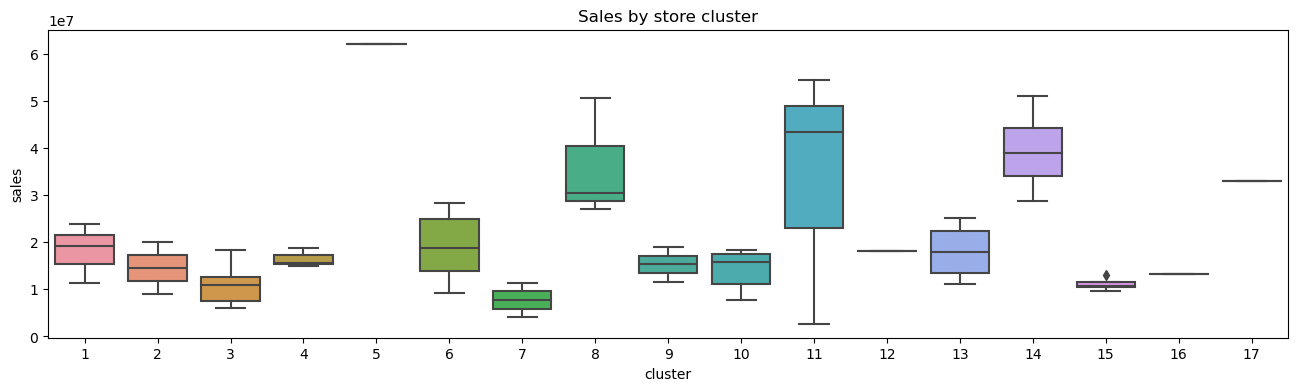

In [33]:
plt.figure(figsize=(16, 4))
sns.boxplot(data=store_sales, y='sales', x='cluster')
plt.title('Sales by store cluster')
plt.show()

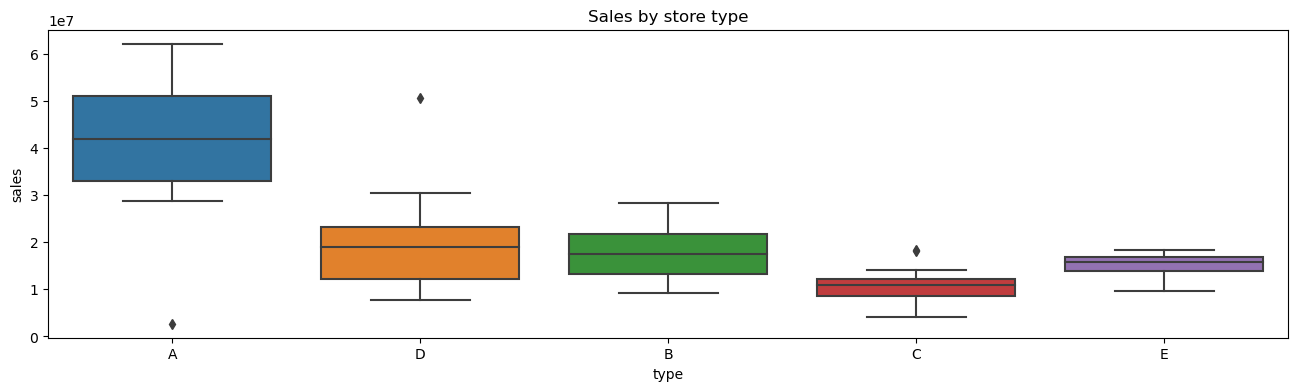

In [32]:
plt.figure(figsize=(16, 4))
sns.boxplot(data=store_sales, y='sales', x='type')
plt.title('Sales by store type')
plt.show()

It seems that store type really helps on distinguishing the overall sales. Lets look at group A:

In [37]:
store_sales[store_sales.type=='A']

,store_nbr,sales,city,state,type,cluster
43,44,6.208755e+07,Quito,Pichincha,A,5
44,45,5.449801e+07,Quito,Pichincha,A,11
46,47,5.094831e+07,Quito,Pichincha,A,14
48,49,4.342010e+07,Quito,Pichincha,A,11
45,46,4.189606e+07,Quito,Pichincha,A,14
47,48,3.593313e+07,Quito,Pichincha,A,14
50,51,3.291149e+07,Guayaquil,Guayas,A,17
49,50,2.865302e+07,Ambato,Tungurahua,A,14
51,52,2.696170e+06,Manta,Manabi,A,11


From here, store 52 doesn't really add up. Let's look a little further.

<AxesSubplot: xlabel='date'>

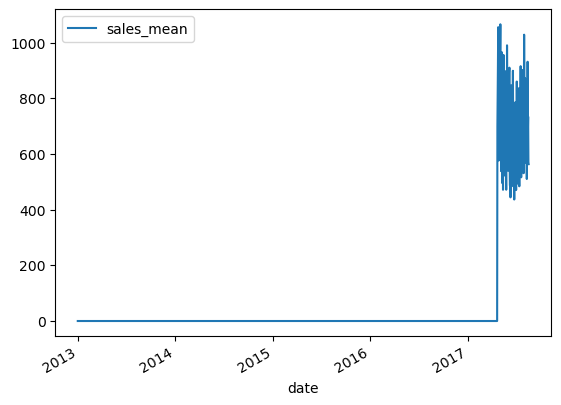

In [42]:
typeA_outlier = train[train.store_nbr==52]
typeA_outlier = typeA_outlier.groupby('date').sales.agg(['mean', 'std'])
typeA_outlier.columns = ['sales_mean', 'sales_std']
typeA_outlier.plot(y='sales_mean')

It seems that this store is pretty new

<AxesSubplot: xlabel='date'>

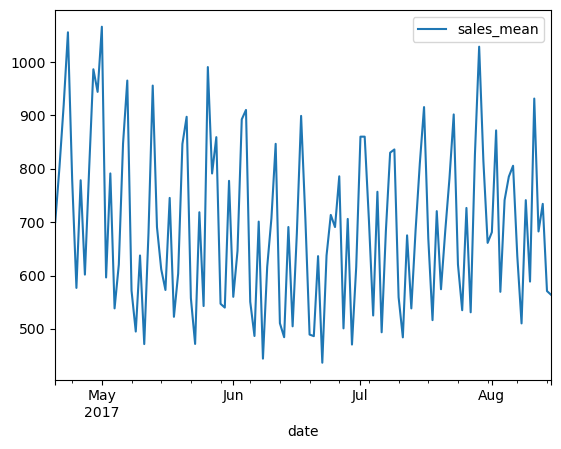

In [43]:
typeA_outlier[typeA_outlier.sales_mean!=0].plot(y='sales_mean')

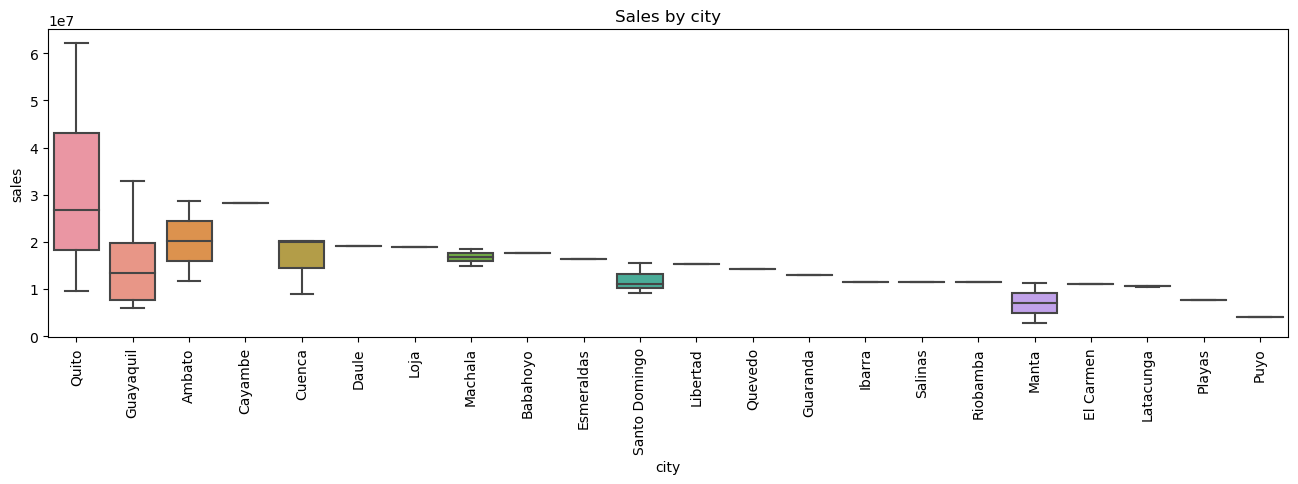

In [34]:
plt.figure(figsize=(16, 4))
sns.boxplot(data=store_sales, y='sales', x='city')
plt.xticks(rotation=90)
plt.title('Sales by city')
plt.show()

### Number of dates with zero sales per store

In [77]:
daily_storeSales = train.groupby(['store_nbr', 'date'], as_index=False).sales.sum()
daily_storeSales['zero_sales'] = daily_storeSales.sales==0
daily_storeSales.set_index('date', inplace=True)

daily_storeSales.groupby('store_nbr').zero_sales.sum().sort_values(ascending=False).head(10)

store_nbr
52    1566
22    1011
42     962
21     934
29     808
20     773
53     515
36     131
18     115
24     106
Name: zero_sales, dtype: int64

In [86]:
daily_storeSales.groupby('store_nbr').zero_sales.sum().sort_values(ascending=False).tail(5)

store_nbr
26    5
27    5
2     5
31    5
54    5
Name: zero_sales, dtype: int64

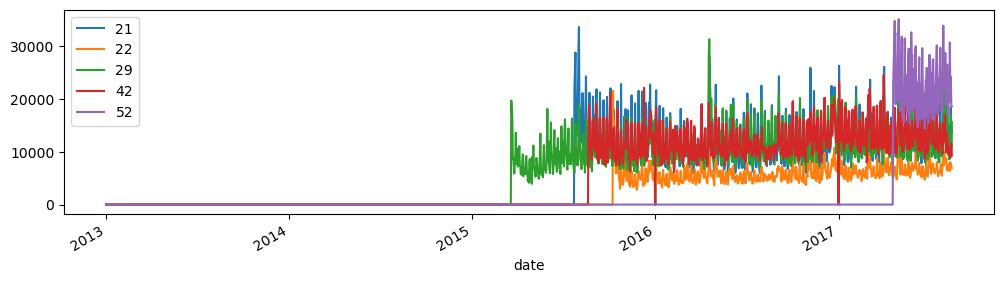

In [83]:
fig, ax = plt.subplots(figsize=(12, 3))
for i, g in daily_storeSales[daily_storeSales.store_nbr.isin([52, 22, 42, 21, 29])].groupby('store_nbr'):
    g.plot(y='sales', ax=ax, label=i)
plt.show()

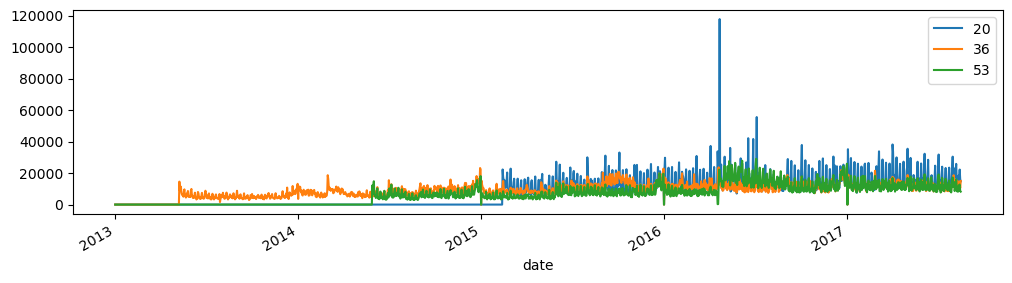

In [84]:
fig, ax = plt.subplots(figsize=(12, 3))

for i, g in daily_storeSales[daily_storeSales.store_nbr.isin([20,53, 36])].groupby('store_nbr'):
    g.plot(y='sales', ax=ax, label=i)
plt.show()

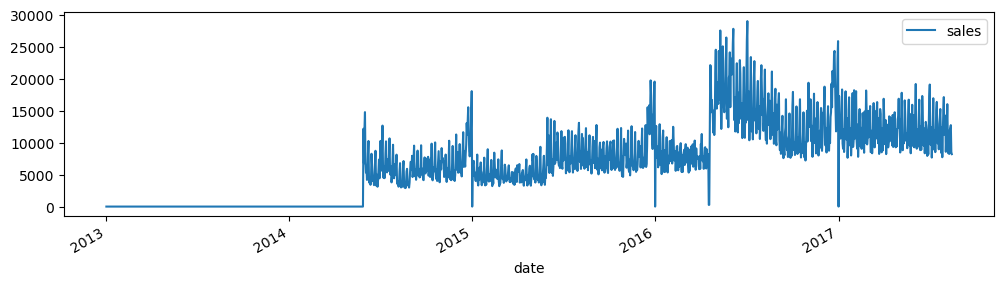

In [85]:
fig, ax = plt.subplots(figsize=(12, 3))

daily_storeSales[daily_storeSales.store_nbr.isin([53])].plot(y='sales', ax=ax)
plt.show()

### Number of dates with zero sales per family

In [138]:
daily_familySales = train.groupby(['family', 'date'], as_index=False).sales.sum()
daily_familySales['zero_sales'] = daily_familySales.sales==0
daily_familySales.set_index('date', inplace=True)

daily_familySales.groupby('family').zero_sales.sum().sort_values(ascending=False).head(15)

family
BOOKS                         1397
BABY CARE                      793
SCHOOL AND OFFICE SUPPLIES     668
LADIESWEAR                     668
PLAYERS AND ELECTRONICS        665
CELEBRATION                    665
PET SUPPLIES                   658
HOME CARE                      637
MAGAZINES                      604
HOME AND KITCHEN II            514
HOME AND KITCHEN I             514
LIQUOR,WINE,BEER               178
PRODUCE                         74
HOME APPLIANCES                 29
HARDWARE                         3
Name: zero_sales, dtype: int64

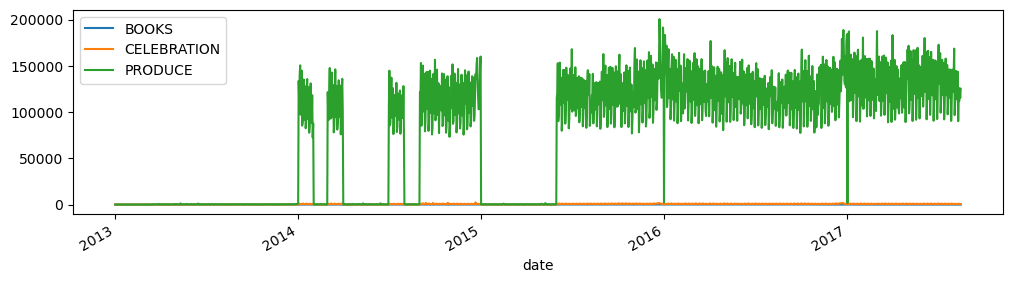

In [143]:
fig, ax = plt.subplots(figsize=(12, 3))
for i, g in daily_familySales[daily_familySales.family.isin(['BOOKS', 'PRODUCE', 'CELEBRATION'])].groupby('family'):
    g.plot(y='sales', ax=ax, label=i)
plt.show()

### Stores closed on the 1st of january

In [88]:
daily_storeSales[(daily_storeSales.store_nbr==54) & (daily_storeSales.zero_sales==True)]

,store_nbr,sales,zero_sales
date,,,
2013-01-01,54,0.0,True
2014-01-01,54,0.0,True
2015-01-01,54,0.0,True
2016-01-01,54,0.0,True
2017-01-01,54,0.0,True


In [89]:
daily_storeSales[(daily_storeSales.store_nbr==10) & (daily_storeSales.zero_sales==True)]

,store_nbr,sales,zero_sales
date,,,
2013-01-01,10,0.0,True
2014-01-01,10,0.0,True
2015-01-01,10,0.0,True
2016-01-01,10,0.0,True
2017-01-01,10,0.0,True


In [94]:
daily_storeSales.reset_index().groupby('date').zero_sales.sum().sort_values(ascending=False).head(20)

date
2013-01-01    53
2016-01-01    53
2017-01-01    53
2015-01-01    53
2014-01-01    52
2013-07-15     8
2013-01-02     8
2013-07-08     8
2013-07-09     8
2013-07-11     8
2013-07-12     8
2013-07-13     8
2013-07-14     8
2013-07-16     8
2013-05-07     8
2013-07-17     8
2013-07-18     8
2013-07-19     8
2013-07-20     8
2013-07-21     8
Name: zero_sales, dtype: int64

In [96]:
daily_storeSales[(daily_storeSales.index=='2014-01-01') & (daily_storeSales.zero_sales==False)]

,store_nbr,sales,zero_sales
date,,,
2014-01-01,25,4992.534400,False
2014-01-01,36,3609.531004,False


In [97]:
stores[stores.store_nbr.isin([25, 36])]

,store_nbr,city,state,type,cluster
24,25,Salinas,Santa Elena,D,1
35,36,Libertad,Guayas,E,10


# Sales by family

In [99]:
storeFamily_sales = train.groupby(['store_nbr', 'family'], as_index=False).sales.sum()
storeFamily_sales = pd.merge(storeFamily_sales, stores, on='store_nbr')
storeFamily_sales.sort_values('sales', ascending=False, inplace=True)

storeFamily_sales.head()

,store_nbr,family,sales,city,state,type,cluster
1431,44,GROCERY I,1.638606e+07,Quito,Pichincha,A,5
1464,45,GROCERY I,1.634975e+07,Quito,Pichincha,A,11
1530,47,GROCERY I,1.551453e+07,Quito,Pichincha,A,14
1497,46,GROCERY I,1.434226e+07,Quito,Pichincha,A,14
1422,44,BEVERAGES,1.341786e+07,Quito,Pichincha,A,5


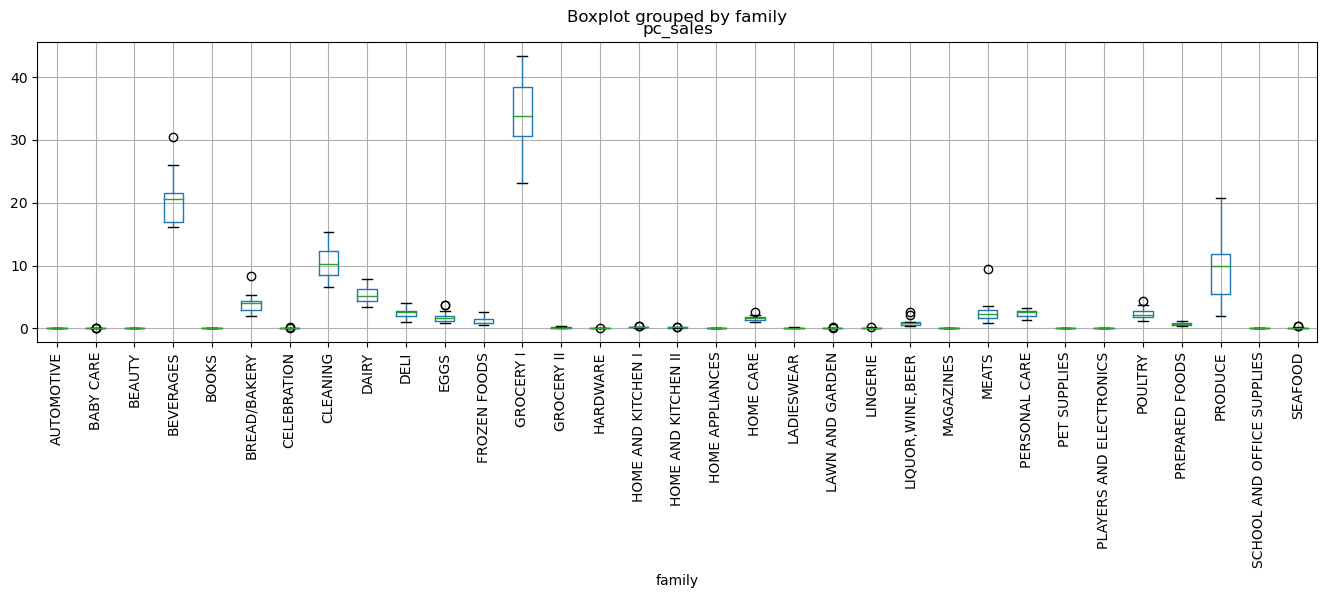

In [113]:
np.random.seed(4)

store_sample = stores.store_nbr.sample(20)
storeFamily_sample = storeFamily_sales[storeFamily_sales.store_nbr.isin(store_sample)]

storeFamily_sample.loc[:, 'total_sales'] = storeFamily_sample.groupby('store_nbr').sales.transform('sum')
storeFamily_sample.loc[:, 'pc_sales'] = 100*storeFamily_sample.sales/storeFamily_sample.total_sales

storeFamily_sample.boxplot(column='pc_sales', by='family', figsize=(16, 4))
plt.xticks(rotation=90)
plt.show()

From here, we see that the most important family categories are Grocery I, Beverages, Cleaning, Produce and Dairy. Some other important ones are bread, deli, eggs and meats. And the distribution seems to be pretty even, most of the time, with not too many outliers in each category.

## Time series analysis of one store

In order to get a better intuition fast, I will analyze only one store selected at random.

In [38]:
def parse_topFamilies(x):
    if x in ['GROCERY I', 'BEVERAGES', 'CLEANING', 'PRODUCE', 'DAIRY']:
        return x
    else:
        return 'other'

In [73]:
sampleStore_sales = train[train.store_nbr==44]
sampleStore_sales['new_family'] = sampleStore_sales.family.map(parse_topFamilies)
sampleStore_sales = sampleStore_sales.groupby(['date', 'new_family'], as_index=False).sum()
sampleStore_sales['weekday'] = sampleStore_sales.date.dt.day_name()
sampleStore_sales['dayOfMonth'] = sampleStore_sales.date.dt.day
sampleStore_sales['sales_rollMean'] = sampleStore_sales.groupby('new_family').sales.transform(lambda x: x.rolling(7).mean())
print(sampleStore_sales.shape)
sampleStore_sales.head()

(10104, 9)


,date,new_family,id,store_nbr,sales,onpromotion,weekday,dayOfMonth,sales_rollMean
0,2013-01-01,BEVERAGES,1257,44,0.0,0,Tuesday,1,NaN
1,2013-01-01,CLEANING,1261,44,0.0,0,Tuesday,1,NaN
2,2013-01-01,DAIRY,1262,44,0.0,0,Tuesday,1,NaN
3,2013-01-01,GROCERY I,1266,44,0.0,0,Tuesday,1,NaN
4,2013-01-01,PRODUCE,1284,44,0.0,0,Tuesday,1,NaN


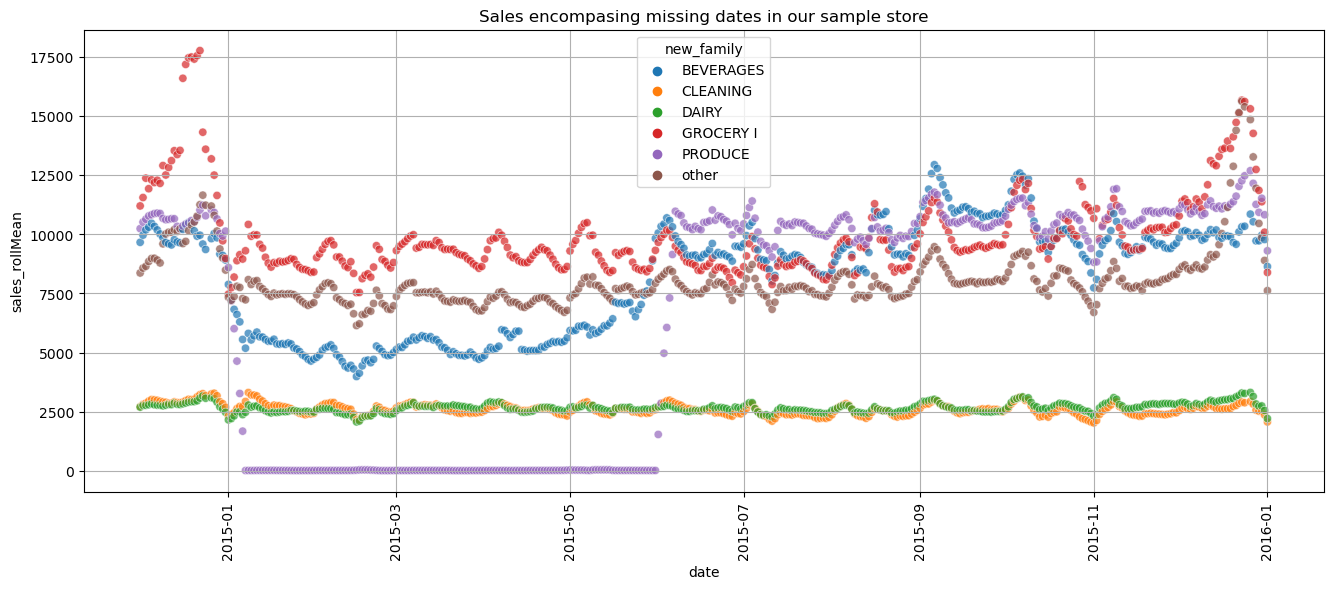

In [92]:
weird_dates = sampleStore_sales[sampleStore_sales.date.between(pd.to_datetime('2014-12-01'), 
                                                               pd.to_datetime('2016-01-01'))]
plt.figure(figsize=(16, 6))
sns.scatterplot(weird_dates, x='date', y='sales_rollMean', hue='new_family', alpha=0.7)
plt.title('Sales encompasing missing dates in our sample store')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=90)
plt.grid()
plt.show()

### Autocorrelations

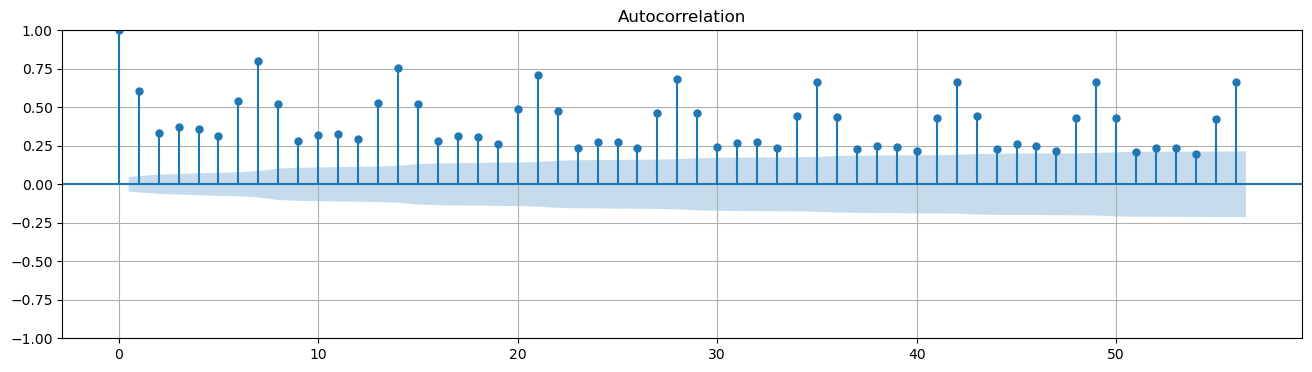

In [135]:
aux = sampleStore_sales.set_index('date').resample('d').sum()

plot_acf(aux.sales, lags=56)
plt.grid()
plt.show()

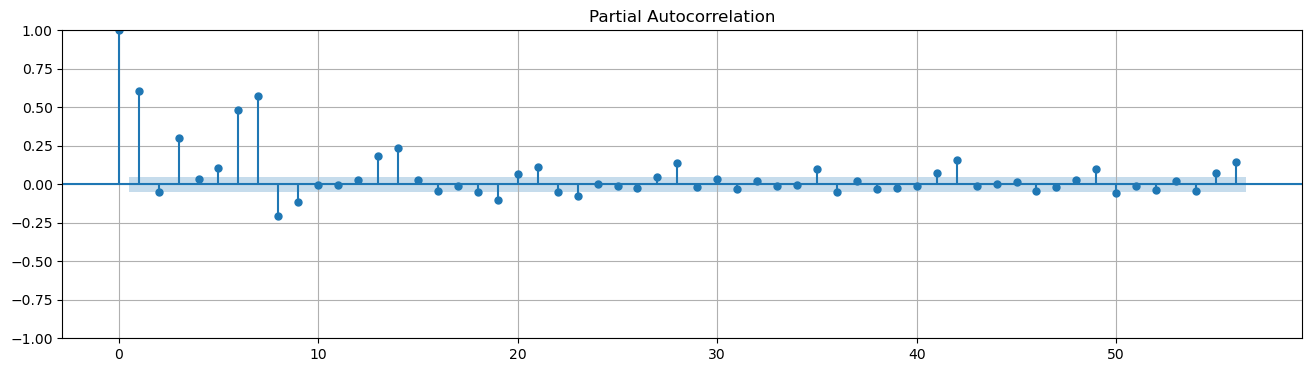

In [134]:
plot_pacf(aux.sales, lags=56)
plt.grid()
plt.show()

### Day of month trend for random samples of stores

It seems that most of the sales are on the first and second day of each month.

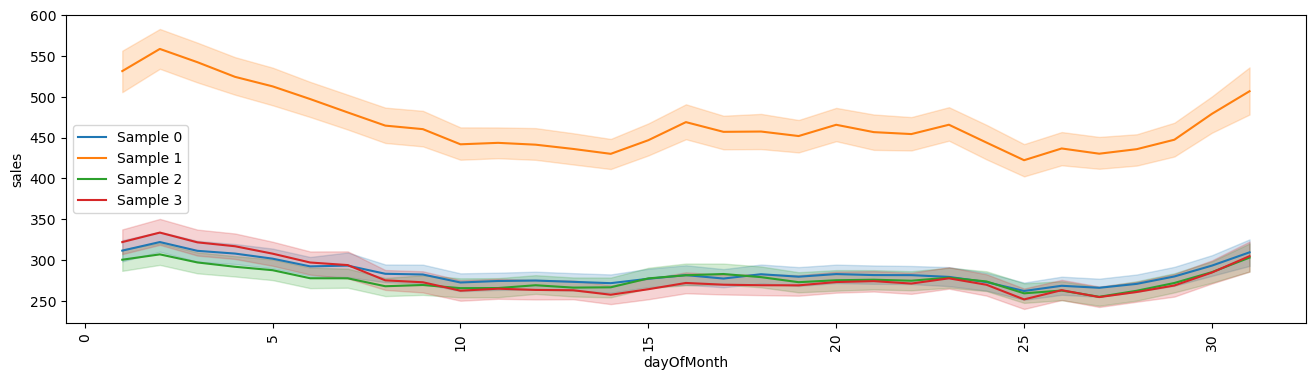

In [91]:
fig, ax = plt.subplots(figsize=(16, 4))

for i in range(4):
    dayOfMonth_sample = train[train.store_nbr.isin(train.store_nbr.sample(10))]
    dayOfMonth_sample['dayOfMonth'] = dayOfMonth_sample.date.dt.day

    sns.lineplot(dayOfMonth_sample, x='dayOfMonth', y='sales', ax=ax, label='Sample %i' %i)

plt.xticks(rotation=90)
plt.show()

### Day of week trend for random samples of stores

Most of the sales are on the weekends, and this seems to be a general trend.

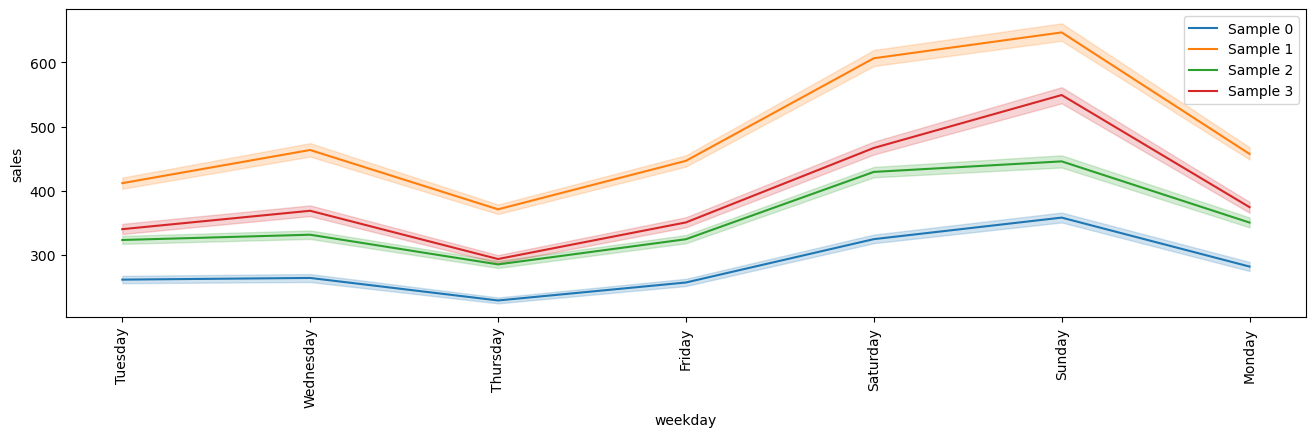

In [93]:
fig, ax = plt.subplots(figsize=(16, 4))

for i in range(4):
    weekday_sample = train[train.store_nbr.isin(train.store_nbr.sample(10))]
    weekday_sample['weekday'] = weekday_sample.date.dt.day_name()

    sns.lineplot(weekday_sample, x='weekday', y='sales', ax=ax, label='Sample %i' %i)

plt.xticks(rotation=90)
plt.show()